In [1]:
import numpy as np
import matplotlib.pyplot as plt
import magnetics
import cloud
from importlib import reload
reload(magnetics)
reload(cloud)
from magnetics import Field

from cloud import Cloud
import matplotlib
from matplotlib.colors import LinearSegmentedColormap


# https://stackoverflow.com/questions/37327308/add-alpha-to-an-existing-matplotlib-colormap
def rgb_white2alpha(rgb, ensure_increasing=False):
    # The most transparent alpha we can use is given by the min of RGB
    # Convert it from saturation to opacity
    alpha = 1. - np.min(rgb, axis=1)
    if ensure_increasing:
        # Let's also ensure the alpha value is monotonically increasing
        a_max = alpha[0]
        for i, a in enumerate(alpha):
            alpha[i] = a_max = np.maximum(a, a_max)
    alpha = np.expand_dims(alpha, -1)
    # Rescale colors to discount the white that will show through from transparency
    rgb = (rgb + alpha - 1) / alpha
    # Concatenate our alpha channel
    return np.concatenate((rgb, alpha), axis=1)

def cmap_white2alpha(cmap, ensure_increasing=True, 
                     register=False):
    # Fetch the cmap callable
    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    # Get the colors out from the colormap LUT
    name=""
    rgb = cmap(np.arange(cmap.N))[:, :3]  # N-by-3
    # Convert white to alpha
    rgba = rgb_white2alpha(rgb, ensure_increasing=ensure_increasing)
    # Create a new Colormap object
    cmap_alpha = matplotlib.colors.ListedColormap(rgba, name=name + "_alpha")
    if register:
        matplotlib.cm.register_cmap(name=name + "_alpha", cmap=cmap_alpha)
    return cmap_alpha



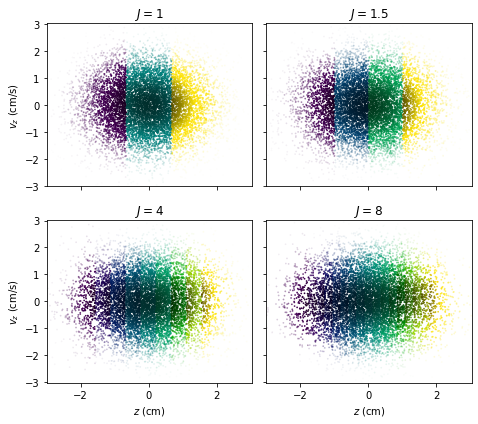

In [2]:
 
fig, axs = plt.subplots(2, 2, figsize=(2*3.375, 6), sharex=True, sharey=True)
for Ji, J in enumerate([1/2, 3/2, 4, 8]):
    r = Ji // 2
    c = Ji % 2

    cloud = Cloud(S=[1,1,1], T=[1e-3, 1e-3, 1e-3], 
                  N=1e4, J=J)
    cloud.initialize_state()
    cloud.set_mJs(coord="z", rule="equal_length")
    base_colors = plt.get_cmap("viridis", int(2*cloud.J+1))
    colors = np.array([list(base_colors(mJi))[:3]
              for mJi in range(int(2*cloud.J +1))])
    for mJi, mJ in enumerate(cloud.mJ_states):
        color_list = [[0.9999, 0.9999, 0.9999], 
                      colors[mJi], 
                      colors[mJi]/2.5]
        cmap = LinearSegmentedColormap.from_list("", color_list)
        cmap = cmap_white2alpha(cmap)
        cloud.plot_phasespace_slice("z", "x", ax=axs[r,c],
                                scatter_kwargs={
                                    "cmap":cmap, "s":3,
                                },
                                Nsample=8e3,
                                mJ_mask=mJ, 
                                contour=False);
        axs[r,c].set_title(r"$J=%s$"%J)

axs[1,0].set_xlabel("$z$ (cm)")
axs[1,0].set_ylabel("$v_z$ (cm/s)")
axs[1,1].set_xlabel("$z$ (cm)")
axs[0,0].set_ylabel("$v_z$ (cm/s)")
plt.tight_layout()
#plt.savefig("cloud_partition_equal_length.pdf", transparent=True)
        


    

In [20]:
geometry = dict(
            config="mop",
            IHH=1,
            IAH=0.8,
            RAH=3.33,
            RHH=3.92,
            AAH=1.81,
            AHH=1.68,
            d=0.086,
            M=5,
            N=2,
            n=[0.0, 0.0, 1.0],
            r0=[0.0, 0.0, 0.0],
            meshspec=[[-2.0, 2.0, 100]] * 3,
        )

field = Field(geometry, save=False, recalc=True, nickname="mop")

Plotting 2D contour slice of gradient...


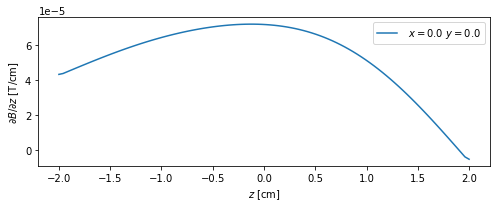

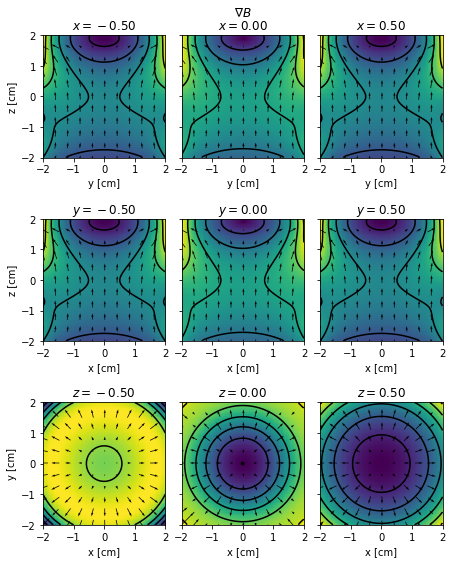

In [24]:
field.plot_linecut(
        axs=None,
        component="z",
        line=[0.0, 0.0, "var"],
        grad_norm=True,
        legend=True,
    )
ax.set_xlim(-1,1)
plt.savefig("mop_grad-norm-B_z-linecut.pdf")
field.plot_slices(grad_norm=True, contours=5, label_contours=False)
plt.savefig("mop_grad-norm-B_slices.pdf")

In [25]:
def cycle_pulses(t0, rule):
    return [{"field": field,
           "t0": 10,
           "tau": 100,
           "shape": "sin",
           "scale": 1000,
           "mJ_coord": "z",
           "mJ_rule": rule,
           "name": "kick"},
           
           {"field": None,
            "tau": 0,
           "t0": t0},
           
           {"field": field,
           "t0": 0,
           "tau": 100,
           "shape": "sin",
           "scale": -1000,
           "mJ_coord": None,
           "mJ_rule": rule,
           "name":"unkick" },
         ]

# New heading

In [26]:
import cloud
reload(cloud)
from cloud import Cloud

def get_ratio(t0, rule, J, gJ, mass):
    C = Cloud(
             S=[0.5, 0.5, 0.5], 
             T=[1e-3, 1e-3, 1e-3], 
             N=1e4, 
             J=J,
             gJ=gJ,
             mass=mass)

    C.initialize_state()
    C.initialize_run(cycle_pulses(t0, rule), dt=1)
    rho_init = C.N/(3*C.S)
    C.run()
    rho_final = C.N/(3*C.S)
    ratio = rho_final / rho_init
    return ratio

def calc_gJ(S, L, J):
    gs = 2.0023
    factor = (J*(J+1) - L*(L+1) + S*(S+1)) 
    factor /= (2*J*(J+1))

    return 1 + (gs - 1)*factor

In [27]:
#https://tel.archives-ouvertes.fr/tel-01571420v2/document
# Appendix A

atoms = ["Li", "Cr", "Er", "Dy"]

symbols = ["^2S_1/2", 
           "^7S_3",
           "^3H_6",
           "^5I8"]
# ground state (S, L, J)
terms = [(1/2, 0, 1/2), 
         (3, 0, 3),
         (1, 5, 6),
         (2, 6, 8)]

masses = np.array([1.15e-26, 
                   8.63e-26, 
                   2.78e-25, 
                   2.70e-25])

Js = np.array([term[2] for term in terms])
gJs = [calc_gJ(*term) for term in terms]

In [31]:
gJs

[2.0023, 2.0023, 1.16705, 1.250575]

In [28]:
muB = 9.27e-24
for atomi, atom in enumerate(atoms):
    J = Js[atomi]
    mass = masses[atomi]
    gJ = gJs[atomi]
    print(atom, "mu_max =", gJ*J, "muB")

Li mu_max = 1.00115 muB
Cr mu_max = 6.0069 muB
Er mu_max = 7.0023 muB
Dy mu_max = 10.0046 muB


In [29]:

t0s = np.geomspace(1e3, 3e5, 30)

rules = ["equal_length", "equal_number"]
ratios = np.zeros((len(Js), len(rules), len(t0s), 3))
for rulei, rule in enumerate(rules):
    for atomi, atom in enumerate(atoms):
        J = Js[atomi]
        mass = masses[atomi]
        gJ = gJs[atomi]
        for t0i, t0 in enumerate(t0s):
            print(atomi, t0i)
            ratios[atomi, rulei, t0i, :] = get_ratio(t0, rule, J, gJ, mass)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
3 0
3 1
3 2
3 3
3 4


In [447]:
ratios.shape

(4, 2, 50, 3)

equal_length
equal_length
equal_length
equal_length
equal_number
equal_number
equal_number
equal_number


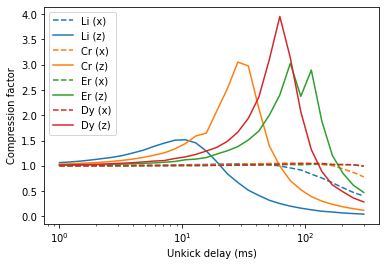

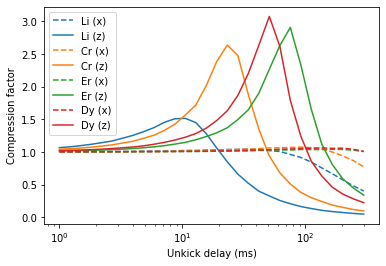

In [37]:

for rulei, rule in enumerate(rules):
    plt.figure()
    for atomi, name in enumerate(atoms):
        print(rule)
        rs = ratios[atomi, rulei,:,:]
        color = f"C{atomi}"
        plt.semilogx(t0s/1e3, rs[:, 1], c=color, ls="--", label=name+" (x)")
        plt.semilogx(t0s/1e3, rs[:, 2], c=color, ls="-", label=name+" (z)")
    plt.legend()
    plt.ylabel("Compression factor")
    plt.xlabel("Unkick delay (ms)")
    plt.savefig(f"compression_factor_vs_unkick_delay_{rule}.pdf")
    

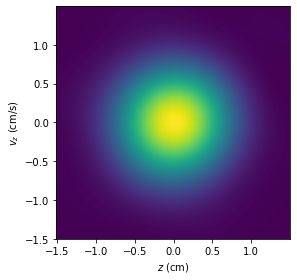

In [235]:

import cloud
reload(cloud)
from cloud import Cloud
C = Cloud(S=[0.5,0.5,0.5], 
          T=[1e-3, 1e-3, 1e-3], 
         N=1e4, 
         J=3/2,
         mass=8e-26)

C.initialize_state()

base_colors = plt.get_cmap("viridis", int(2*C.J+1))
colors = np.array([list(base_colors(mJi))[:3]
          for mJi in range(int(2*C.J +1))])
fig, ax = plt.subplots(1,1)
for mJi, mJ in enumerate(C.mJ_states):
    color_list = [[0.9999, 0.9999, 0.9999], 
                  colors[mJi], 
                  colors[mJi]/2.5]
    cmap = LinearSegmentedColormap.from_list("", color_list)
    cmap = cmap_white2alpha(cmap)
    C.plot_phasespace_slice("z", "x", ax=ax,
                            scatter_kwargs={
                                "cmap":cmap, "s":3,
                            },
                            Nsample=None,
                            mJ_mask=mJ, 
                            contour=False,
                            imshow=True,
                            scatter=False);

ax.set_xlabel("$z$ (cm)")
ax.set_ylabel("$v_z$ (cm/s)")
ax.set_xlabel("$z$ (cm)")
ax.set_ylabel("$v_z$ (cm/s)")
plt.tight_layout()

In [ ]:
C.xs.shape

In [103]:
C.states.shape

(211, 10000, 7)